In [1]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

In [2]:
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import xclimate as xclim

In [3]:
variables = [
    "EFLX_LH_TOT_month_1",
    "TLAI_month_1",
]

time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"

fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))
fhist["EFLX_LH_TOT_clim_1"] = fhist["EFLX_LH_TOT_month_1"].weighted(fhist["EFLX_LH_TOT_month_1"].time.dt.days_in_month).mean("time")

  EFLX_LH_TOT_month_1
  TLAI_month_1


In [4]:
nb = 15
mask_type = "mask_glc80_snow80"
qbin_variables = [
    "EFLX_LH_TOT_clim_1",
    "FCEV_clim_1",
    "FCTR_clim_1",
    "FGEV_clim_1",
    "TLAI_clim_1",

    "DELTA_EFLX_LH_TOT_clim_1",
    "DELTA_FCEV_clim_1",
    "DELTA_FCTR_clim_1",
    "DELTA_FGEV_clim_1",
    "DELTA_TLAI_clim_1",
]
rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/qbin")

grid = xclim.load_fhist_ppe_grid()

qbin = {}
for v in qbin_variables:
    if "cor" in v:
        t = "1950-2014"
    else:
        t = "1995-2014"

    qbin[v] = xr.open_mfdataset(
        list((rootdir / mask_type / v).glob(f"qbin{nb}.{t}.TIMEagg.{v}.*.nc")),
        combine="nested",
        concat_dim="member",
    ).sortby("member").reindex_like(grid, method="nearest", tolerance=1e-3)

In [21]:
bs = {}
sg = {}
for v in ["EFLX_LH_TOT", "FCTR", "FCEV", "FGEV", "TLAI"]:
    print(v)
    bs[v], sg[v] = xclim.full_bin_stats(
        z=fhist["EFLX_LH_TOT_clim_1"].sel(member=slice(1, None)) - fhist["EFLX_LH_TOT_clim_1"].sel(member=0),
        x_bin=qbin[f"{v}_clim_1"].x_bin.sel(member=slice(1, None)),
        y_bin=qbin[f"DELTA_{v}_clim_1"].x_bin,
        xnb=nb,
        ynb=nb,
        z_time_coord=None,
        alpha=0.05,
        n_min=20,
    )

EFLX_LH_TOT
FCTR
FCEV
FGEV
TLAI


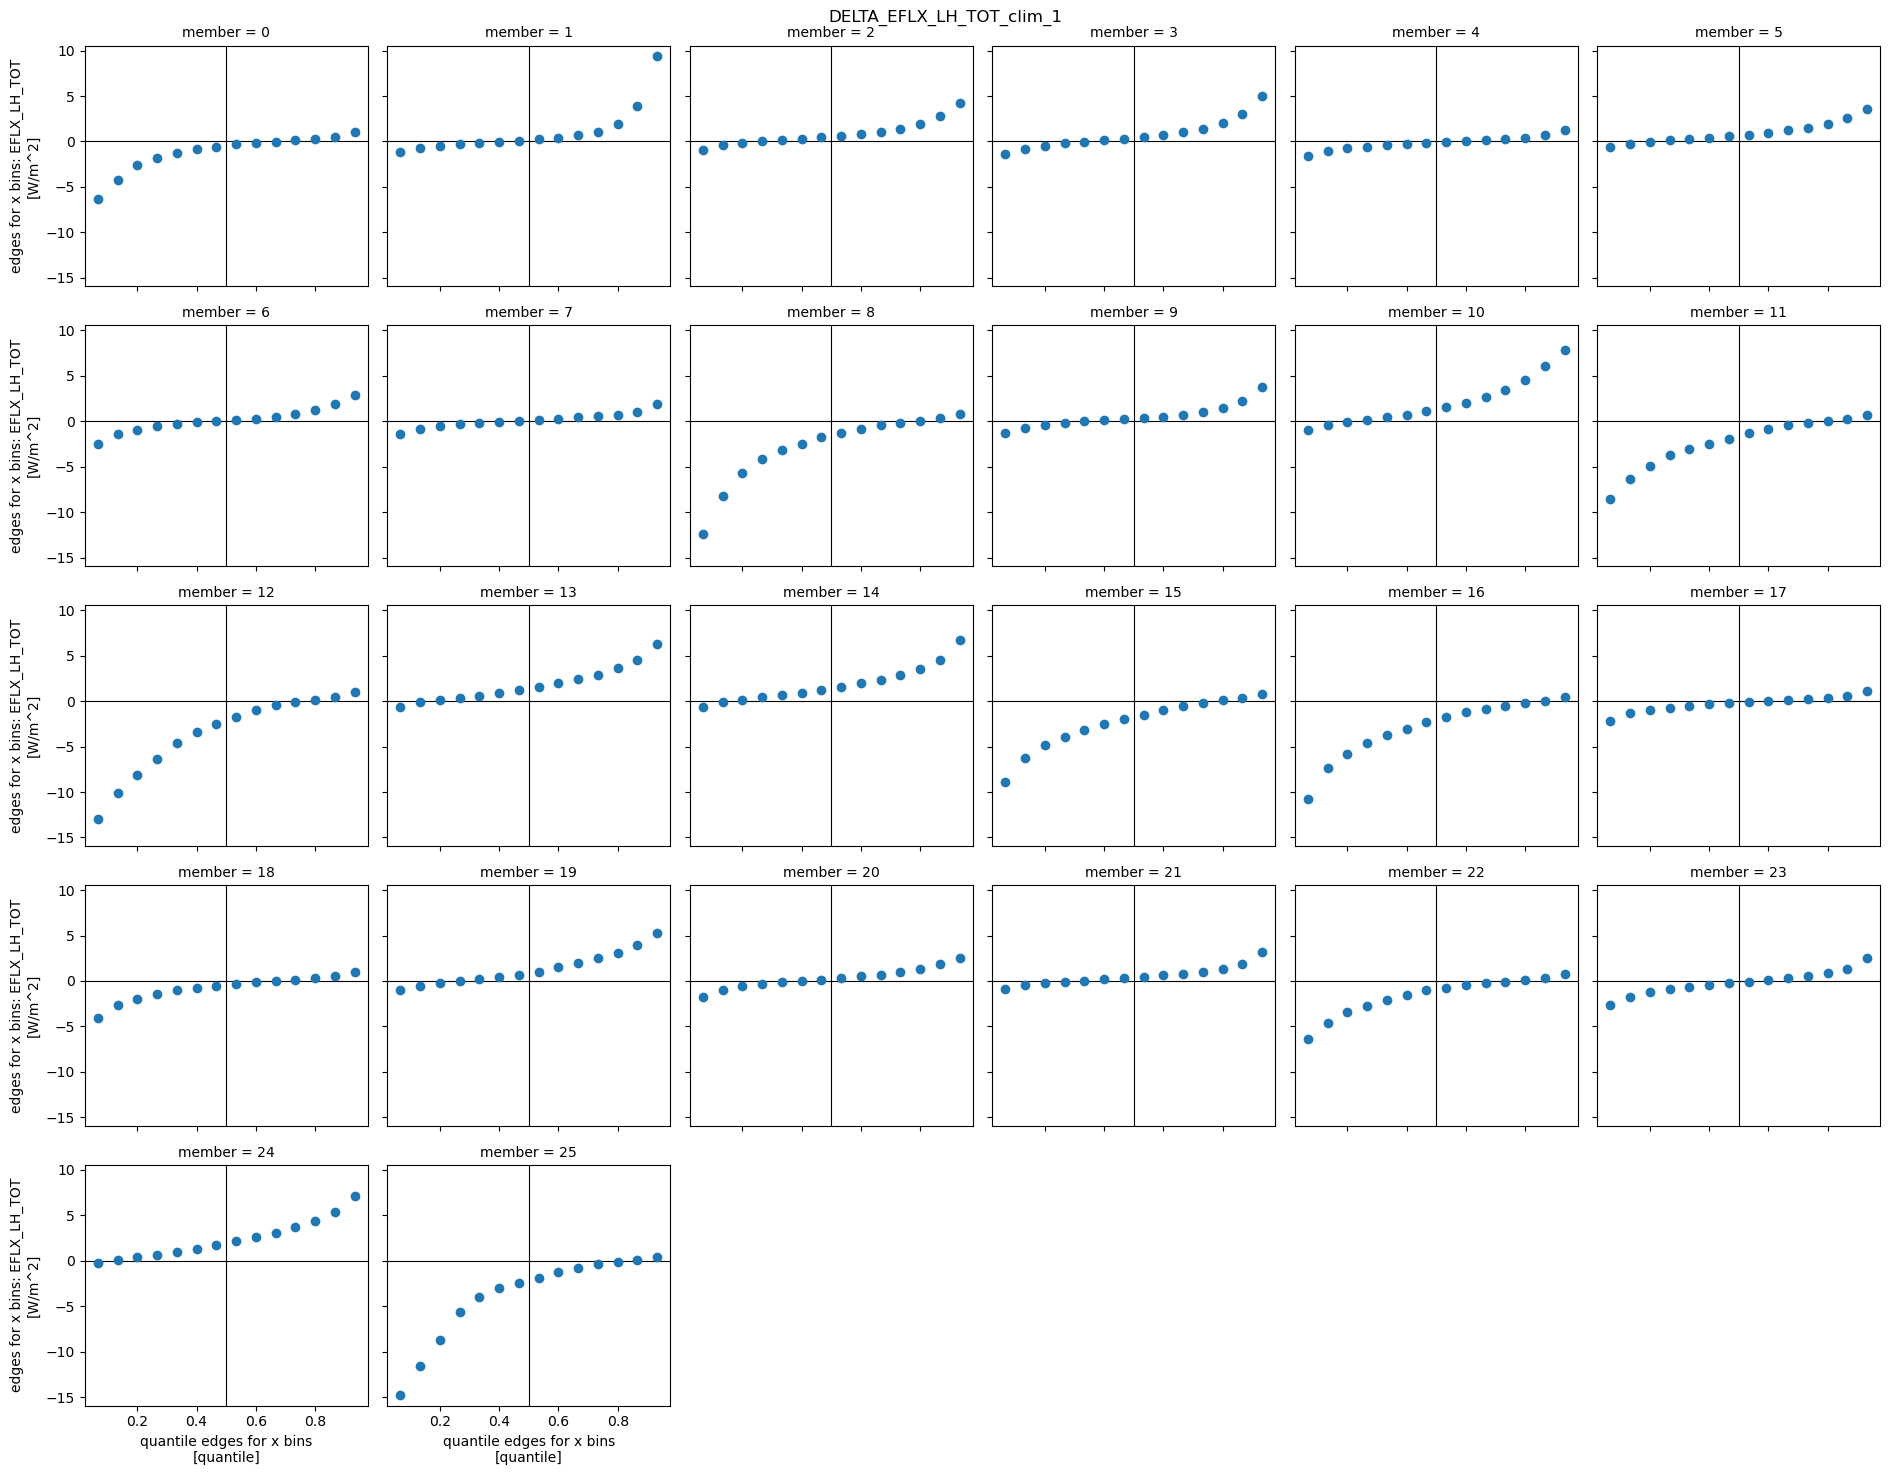

In [12]:
fg = qbin["DELTA_EFLX_LH_TOT_clim_1"].x_edge.isel(qx=slice(1, -1)).plot(col="member", col_wrap=6, lw=0, marker="o")
ax = fg.axs.flatten()

for i, m in enumerate(qbin["DELTA_EFLX_LH_TOT_clim_1"].member):
    ax[i].axhline(0, lw=0.8, c="k", zorder=0)
    ax[i].axvline(0.5, lw=0.8, c="k", zorder=0)

plt.suptitle("DELTA_EFLX_LH_TOT_clim_1")
plt.tight_layout()

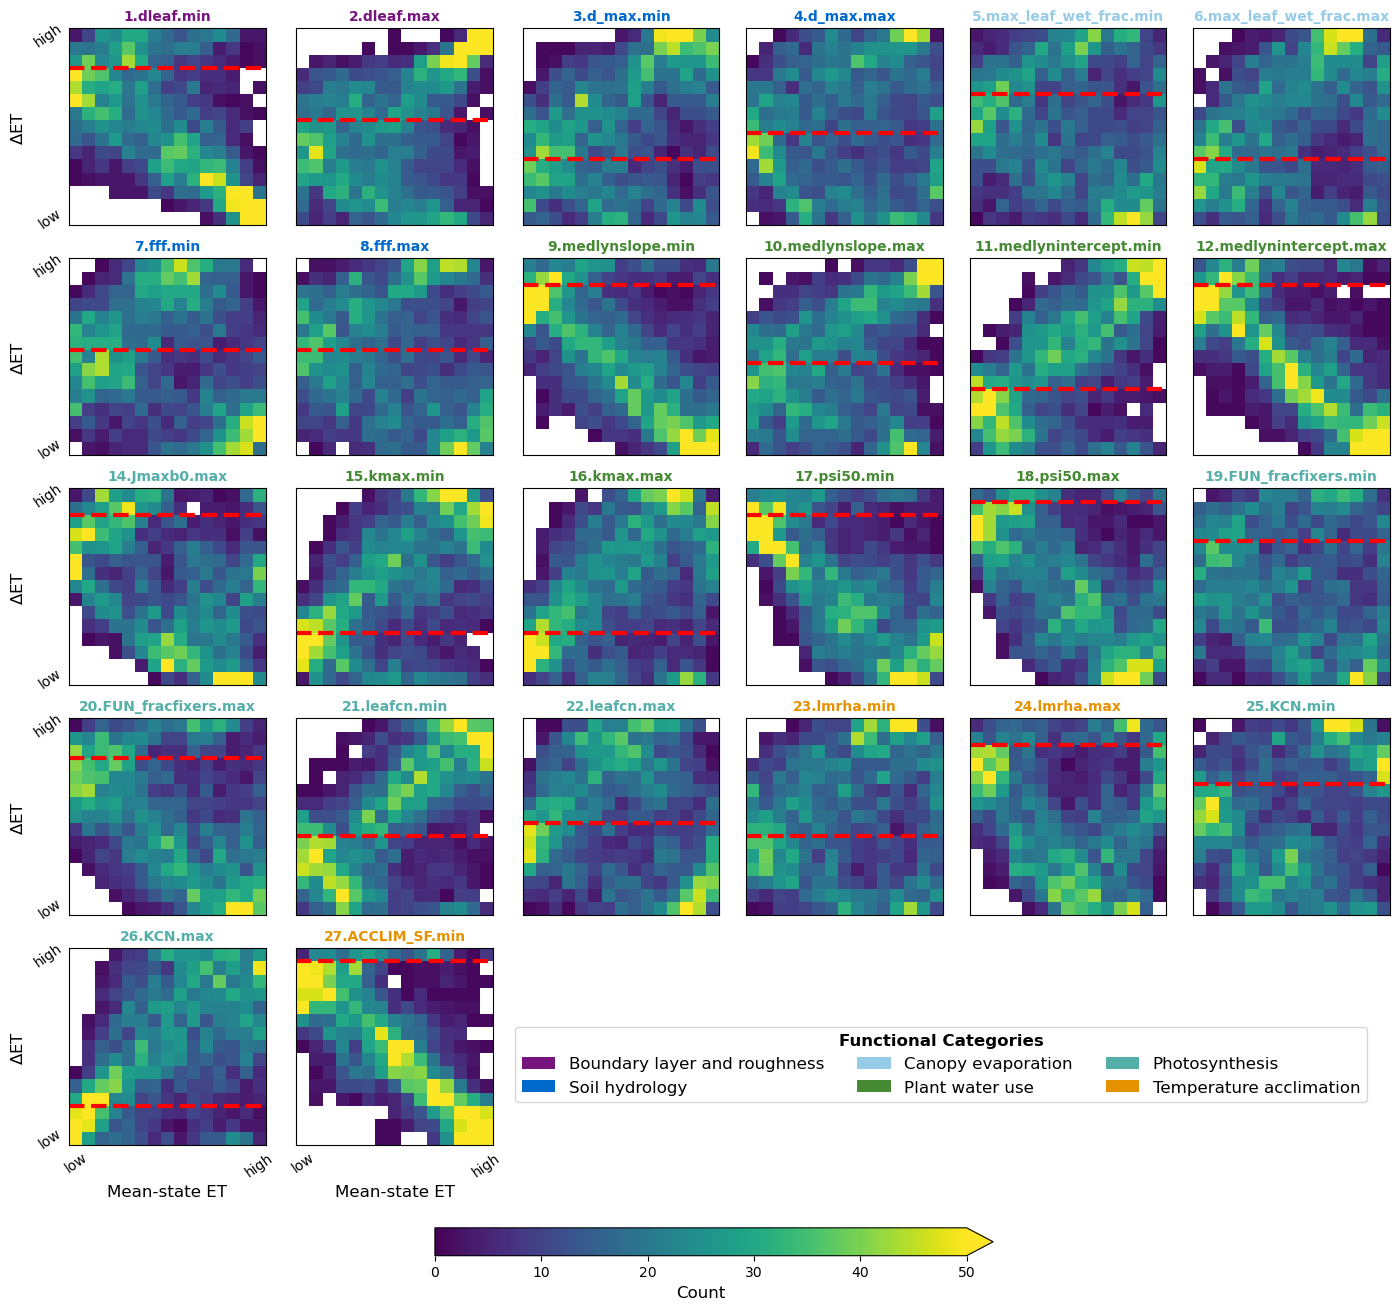

In [12]:
fig, axs = xclim.plot.plot_fhist_joint_dist(
    bs["EFLX_LH_TOT"].sel(stats_name="n"), nb, "Count", "Mean-state ET", "$\\Delta$ET",
    cmap="viridis", vmin=0, vmax=50
)

ax = axs.flatten()
y_edge = qbin["DELTA_EFLX_LH_TOT_clim_1"].x_edge
for i, m in enumerate(qbin["DELTA_EFLX_LH_TOT_clim_1"].member):
    idx = np.searchsorted(y_edge.isel(member=i).values, 0)
    ax[i].axhline(idx + 1, ls="--", c="r", lw=3)

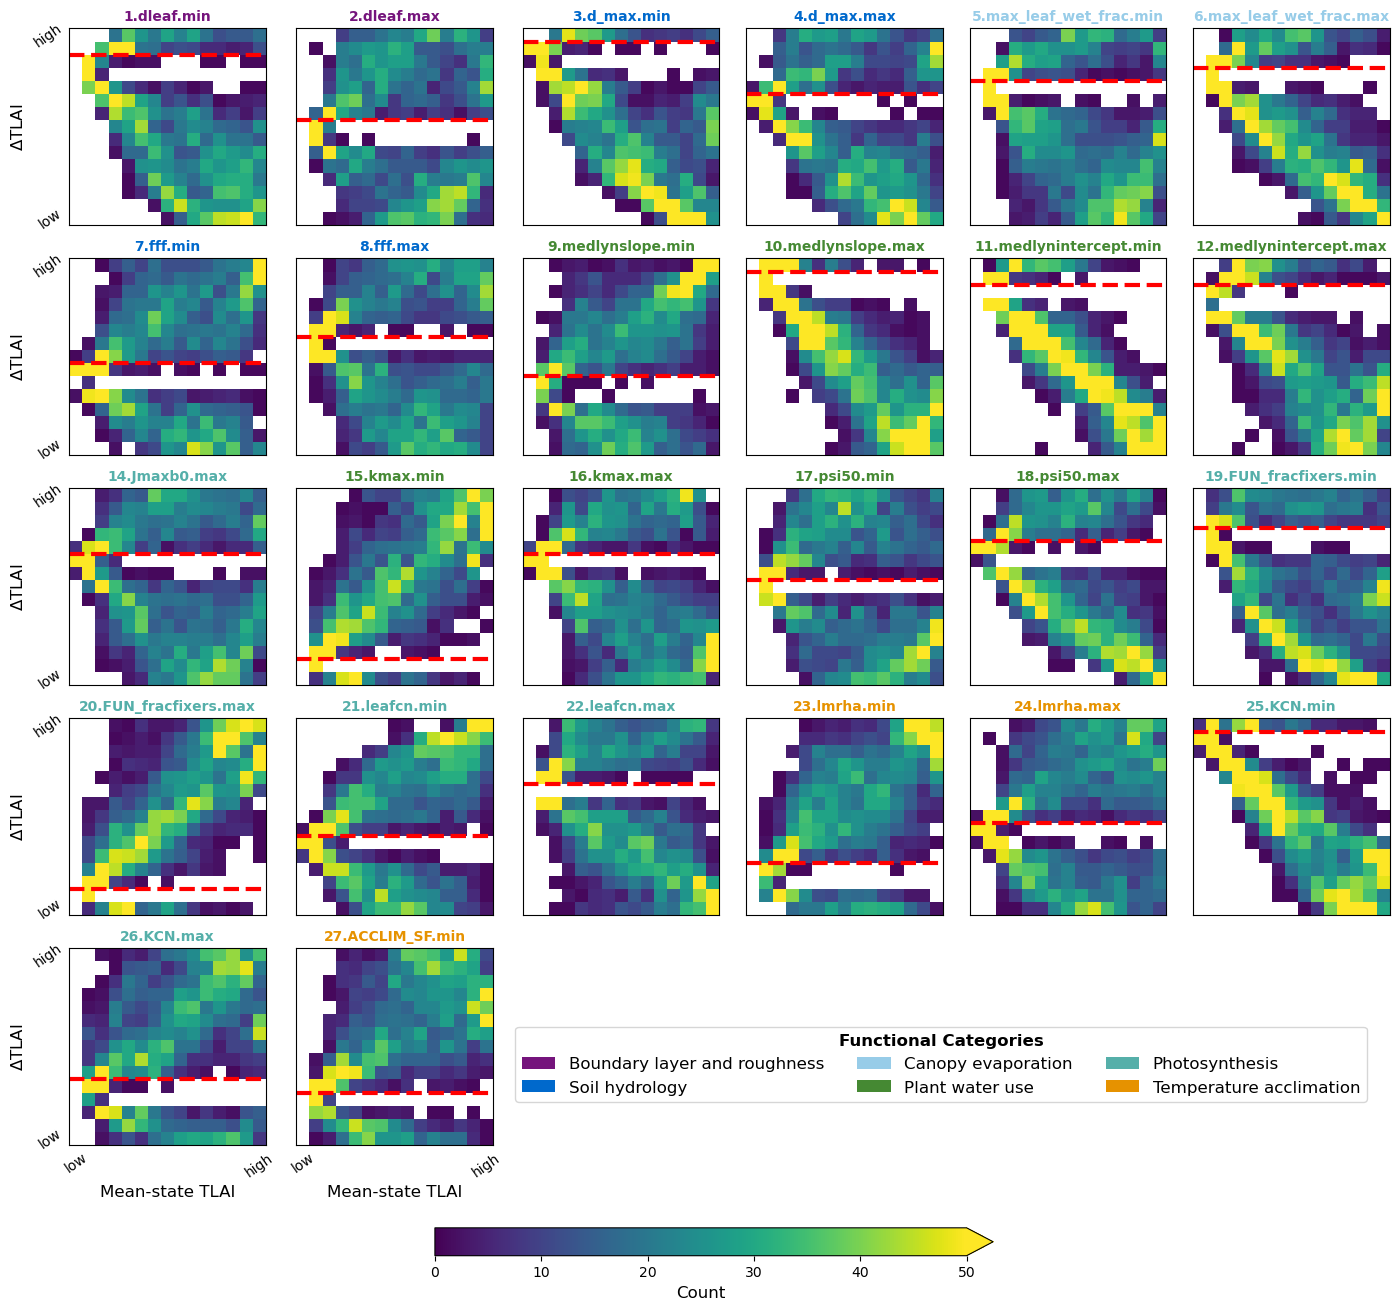

In [17]:
fig, axs = xclim.plot.plot_fhist_joint_dist(
    bs["TLAI"].sel(stats_name="n"), nb, "Count", "Mean-state TLAI", "$\\Delta$TLAI",
    cmap="viridis", vmin=0, vmax=50
)

ax = axs.flatten()
y_edge = qbin["DELTA_TLAI_clim_1"].x_edge
for i, m in enumerate(qbin["DELTA_TLAI_clim_1"].member):
    idx = np.searchsorted(y_edge.isel(member=i).values, 0)
    ax[i].axhline(idx + 1, ls="--", c="r", lw=3)

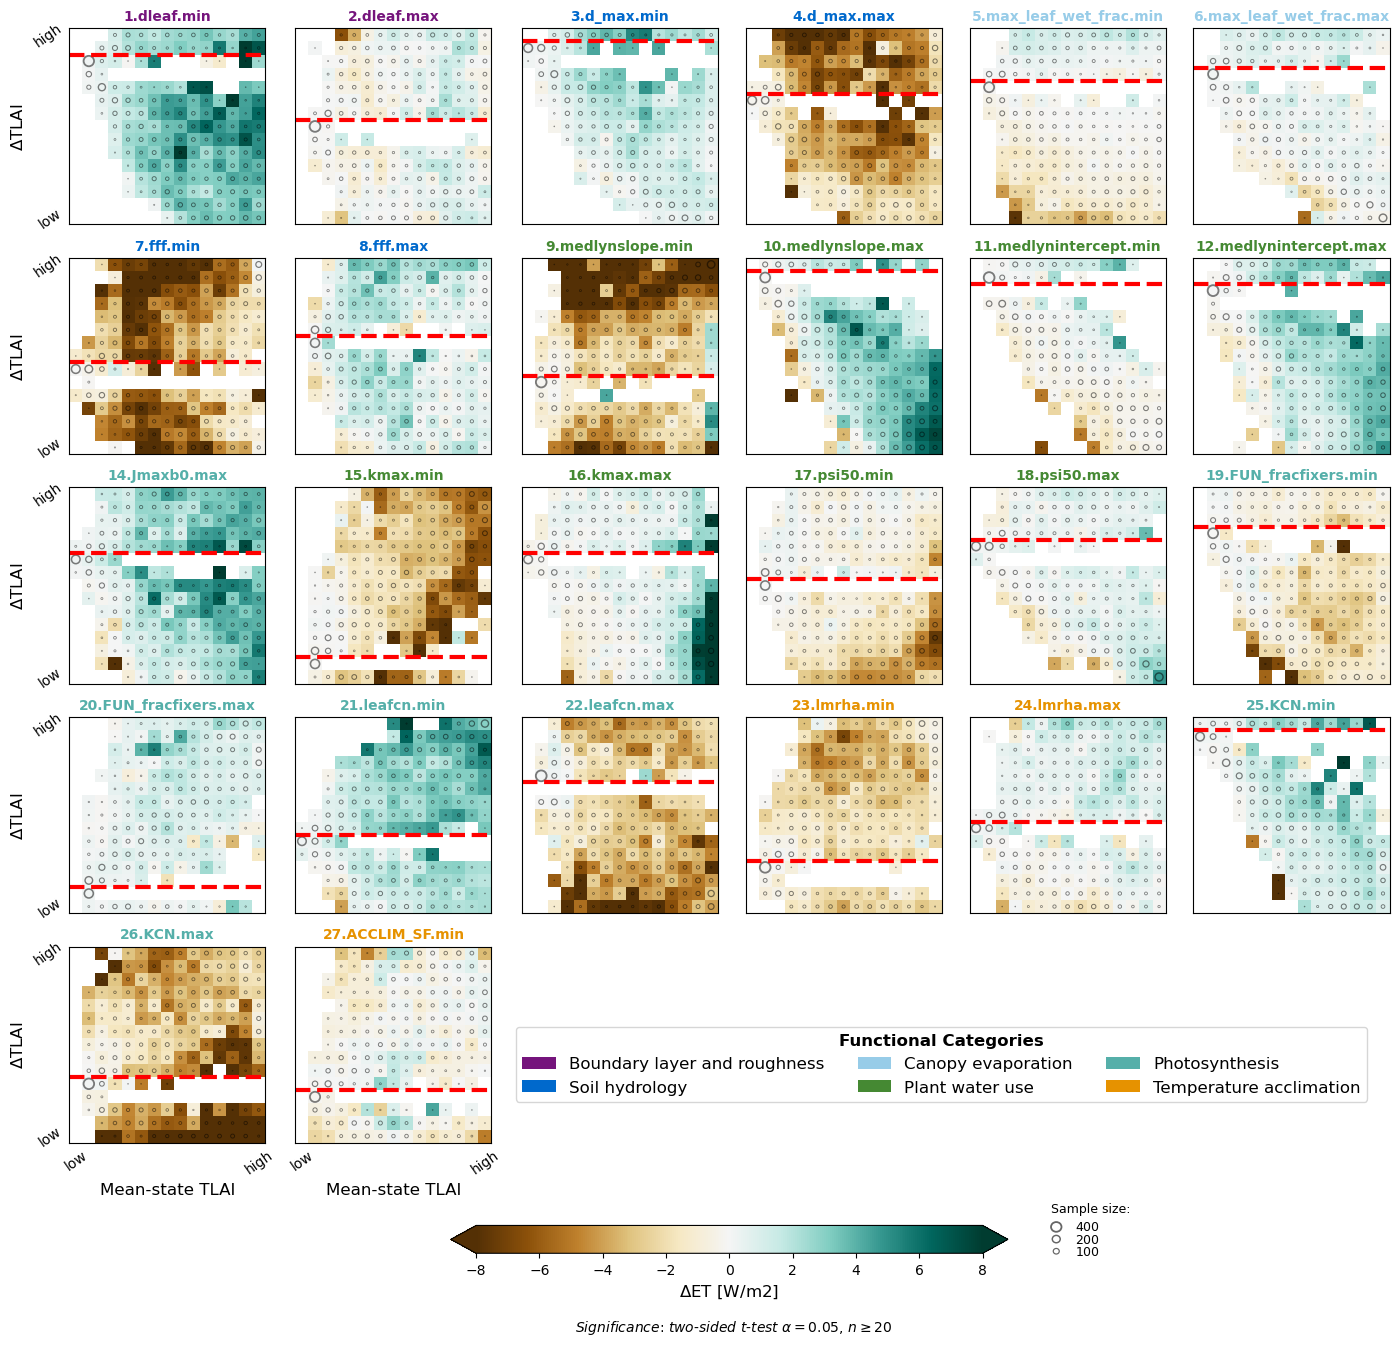

In [22]:
fig, axs = xclim.plot.plot_fhist_binned_mean(
    bs["TLAI"].sel(stats_name="mean"), bs["TLAI"].sel(stats_name="n"), nb, "$\\Delta$ET [W/m2]", "Mean-state TLAI", "$\\Delta$TLAI",
    cmap="BrBG", vmin=-8, vmax=8, signif={"alpha": 0.05, "n_min": 20}
)

ax = axs.flatten()
y_edge = qbin["DELTA_TLAI_clim_1"].x_edge
for i, m in enumerate(qbin["DELTA_TLAI_clim_1"].member):
    idx = np.searchsorted(y_edge.isel(member=i).values, 0)
    ax[i].axhline(idx + 1, ls="--", c="r", lw=3)

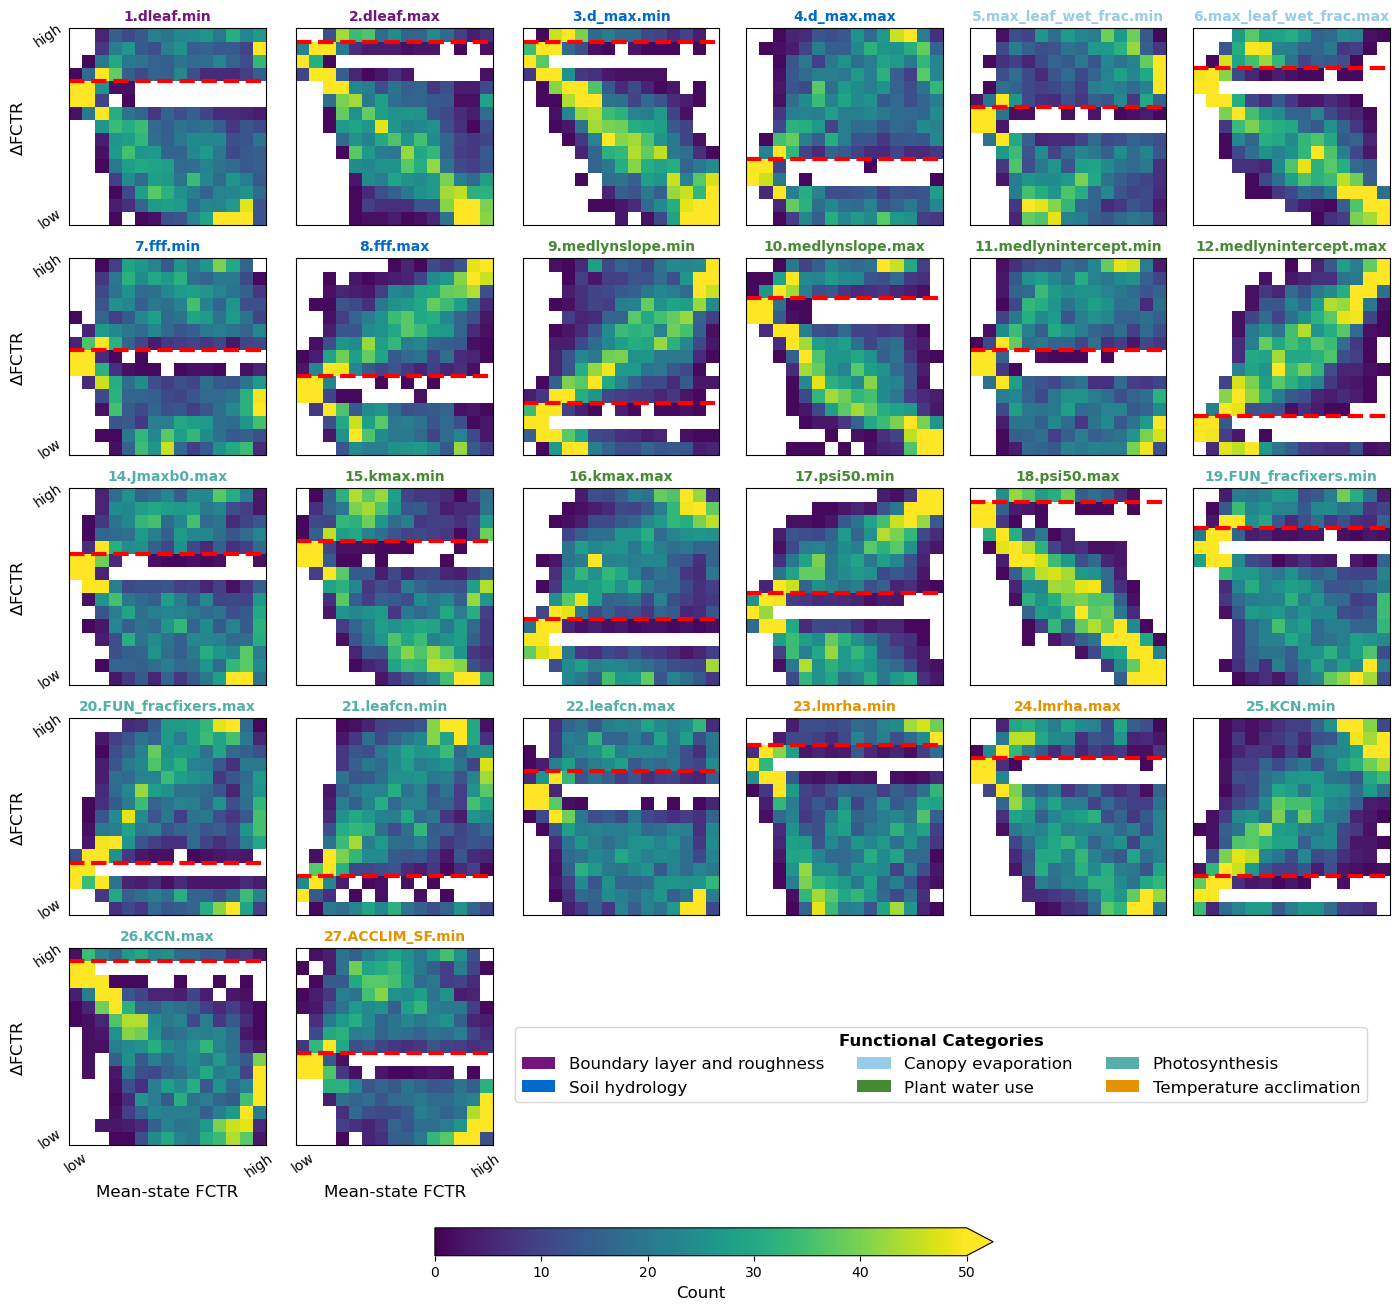

In [18]:
fig, axs = xclim.plot.plot_fhist_joint_dist(
    bs["FCTR"].sel(stats_name="n"), nb, "Count", "Mean-state FCTR", "$\\Delta$FCTR",
    cmap="viridis", vmin=0, vmax=50
)

ax = axs.flatten()
y_edge = qbin["DELTA_FCTR_clim_1"].x_edge
for i, m in enumerate(qbin["DELTA_FCTR_clim_1"].member):
    idx = np.searchsorted(y_edge.isel(member=i).values, 0)
    ax[i].axhline(idx + 1, ls="--", c="r", lw=3)